In [3]:
mp = 0.93827                                                           #proton mass
pz = 158.0                                                             #beam momentum
root_s = (2 * mp * (mp + (mp ** 2 + pz ** 2) ** 0.5)) ** 0.5           #sqrt(s)
norm = 3.141593 * root_s / 2                                           #normalization in new coordinats
sig_trig = 28.23                                                       #trigger cross section

> ## Generating

In [4]:
import sys

sys.path.insert(0, '/opt/homebrew/Cellar/pythia/8.309/lib')

import pythia8

In [5]:
N_events = int(1e7) 
ids = [-211, 211, -321, 321]

In [6]:
import os
from tqdm import tqdm

In [7]:
def gen_data(exp_name, conf_file, tune_pp=14, n_events=int(1e6)):

    try:
    
        os.mkdir(f'gen_data/{exp_name}')
    
    except FileExistsError: pass

    pythia = pythia8.Pythia("", False)

    files = dict(zip(ids, [open(f'gen_data/{exp_name}/{id}.csv', 'w') for id in ids]))

    for id in ids: files[id].write('pT,xF,E\n')

    pythia.readFile(conf_file)
    pythia.readString(f'Tune:pp = {tune_pp}')

    boost = pythia8.Vec4()
    boost.pz(mp * ((1 + (pz / mp) ** 2) ** 0.5 - 1) ** 0.5)
    boost.e((boost.pz() ** 2 + mp ** 2) ** 0.5)

    pythia.init()

    for _ in tqdm(range(n_events)):

        if not pythia.next(): continue
        
        entries = pythia.event.size()

        for j in range(entries):

            particle = pythia.event[j]

            id = particle.id()
            
            if abs(int(id)) == 211 or abs(int(id)) == 321:

                P_mu = particle.p()

                P_mu.bstback(boost)

                pT = P_mu.pT()
                xF = 2 * P_mu.pz() / root_s
                E = P_mu.e()

                files[id].write(f'{pT},{xF},{E}\n')

    sig_total = pythia.getSigmaTotal()

    sigma_file = open(f'gen_data/{exp_name}/sigma_total.txt', 'w')
    sigma_file.write(f'{sig_total}')
    sigma_file.close()

    for id in ids: files[id].close()

In [8]:
tunes = {'primitive': {'tune_pp': 1},
         'monash': {'tune_pp': 14},
         'atlas_a14': {'tune_pp': 19}}

In [551]:
for tune in tunes.keys():

    gen_data(exp_name=tune,
         conf_file='../exp_data/na49/config.cmnd', 
         tune_pp=tunes[tune]['tune_pp'],
         n_events=N_events)

100%|██████████| 10000000/10000000 [26:19<00:00, 6330.48it/s] 


LHAPDF 6.5.3 loading /opt/homebrew/Cellar/lhapdf/6.5.3/share/LHAPDF/cteq6l1/cteq6l1_0000.dat

  0%|          | 624/10000000 [00:00<26:46, 6222.83it/s]


cteq6l1 PDF set, member #0, version 4; LHAPDF ID = 10042
LHAPDF 6.5.3 loading /opt/homebrew/Cellar/lhapdf/6.5.3/share/LHAPDF/cteq6l1/cteq6l1_0000.dat
cteq6l1 PDF set, member #0, version 4; LHAPDF ID = 10042


100%|██████████| 10000000/10000000 [30:15<00:00, 5507.52it/s] 


In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 24})
plt.rcParams['image.cmap'] = 'plasma'

In [10]:
sig_totals = {}

for tune in tunes.keys():

    sigma_file = open(f'gen_data/{tune}/sigma_total.txt', 'r')
    sig_total = float(sigma_file.readline())
    sigma_file.close()

    sig_totals[tune] = sig_total

In [11]:
bins_file = open('../exp_data/na49/binning.bin', 'r')

In [12]:
bins = []

for num, line in enumerate(bins_file.readlines()):

    if num % 2 == 0:
        
        a = line.split('|')

        for bin in a:

            bin = bin.replace('(', '').replace(')', '').replace(' ', '')
            bins.append(list(map(float, bin.split(','))))

bins = np.array(bins)

bins_file.close()

In [14]:
def xsect_calc(data, sig_total):

    xsect = []
    err = []

    for bin in bins:

        xF = bin[0]
        pT = bin[1]

        dxF = bin[2]
        dpT = bin[3]

        mask_for_bin = (data['xF'] > xF - dxF / 2) * (data['xF'] < xF + dxF / 2) * (data['pT'] > pT - dpT / 2) * (data['pT'] < pT + dpT / 2)

        dn = data[mask_for_bin]['E'].size

        dp3 = dxF * 2 * pT * dpT

        E = data[mask_for_bin]['E']

        xsect.append((E * (sig_total / N_events) * (dn / dp3) / norm).mean())
        err.append((E * (sig_total / N_events) * (dn / dp3) / norm).std())

    xsect = np.where(np.isnan(xsect), 0, xsect)
    err = np.where(np.isnan(err), 0, err)

    return xsect, err

In [15]:
def calc_metric(func, xsect, err, ref):

    res = []

    for num, bin in enumerate(bins):

        mask = (ref['xF'] == bin[0]) * (ref['pT'] == bin[1])

        if sum(mask) != 0:

            res.append(func(y_hat=xsect[num], y=ref['xsect'][mask].values[0],
                            y_hat_err=err[num], y_err=ref['error'][mask].values[0]))

    return np.where(np.isnan(res), 0, res)

In [16]:
def mse(y_hat, y, y_hat_err=None, y_err=None):

    return (y_hat - y) ** 2

In [17]:
def chi_square(y_hat, y, y_hat_err=None, y_err=None):

    return (y_hat - y) ** 2 / (y_hat_err ** 2 + y_err ** 2)

In [18]:
def plot_compare(tunes, xsect, err, ref):

    n = ref['xF'].unique().size

    plt.figure(figsize=(8 * n, 24))
    plt.tight_layout(pad=10.0)

    for num, xF in enumerate(ref['xF'].unique()):

        pT_axis = np.intersect1d(bins[:, 1][bins[:, 0] == xF][::-1], ref['pT'][ref['xF'] == xF])

        mse = {}
        chi_sqr = {}

        for tune in tunes:

            mse[tune] = ((xsect[tune][(bins[:, 0] == xF) * np.isin(bins[:, 1], pT_axis)][::-1] - \
            ref['xsect'][(ref['xF'] == xF) * np.isin(ref['pT'], pT_axis)]) ** 2).mean()

            chi_sqr[tune] = ((xsect[tune][(bins[:, 0] == xF) * np.isin(bins[:, 1], pT_axis)][::-1] - \
            ref['xsect'][(ref['xF'] == xF) * np.isin(ref['pT'], pT_axis)]) ** 2 / \
            (err[tune][(bins[:, 0] == xF) * np.isin(bins[:, 1], pT_axis)][::-1] ** 2 + \
            ref['error'][(ref['xF'] == xF) * np.isin(ref['pT'], pT_axis)] ** 2)).mean()

            pass

        plt.subplot(3, n, n * 0 + (num + 1))
        plt.ticklabel_format(scilimits=(0, 1), style='sci')

        for tune in tunes:

            plt.errorbar(pT_axis, xsect[tune][(bins[:, 0] == xF) * np.isin(bins[:, 1], pT_axis)][::-1],
                         yerr=err[tune][(bins[:, 0] == xF) * np.isin(bins[:, 1], pT_axis)][::-1],
                         label=f'{tune}, $\chi^2$={chi_sqr[tune]:.4}')
            
        plt.errorbar(pT_axis, ref['xsect'][(ref['xF'] == xF) * np.isin(ref['pT'], pT_axis)], 
                    yerr=ref['error'][(ref['xF'] == xF) * np.isin(ref['pT'], pT_axis)],
                    label='exp')
#        plt.xlim((0, 2.15))
        plt.legend()
        plt.title(f'$x_F={xF}$', fontdict={'size': 44})
        if num == 0:
            plt.ylabel('$f$', fontdict={'size': 44})
        plt.xticks(pT_axis, labels='')

        plt.subplot(3, n, n * 1 + (num + 1))
        plt.ticklabel_format(scilimits=(0, 1), style='sci')

        for tune in tunes:

            plt.errorbar(pT_axis, xsect[tune][(bins[:, 0] == xF) * np.isin(bins[:, 1], pT_axis)][::-1],
                         yerr=err[tune][(bins[:, 0] == xF) * np.isin(bins[:, 1], pT_axis)][::-1], label=tune)
            
        plt.errorbar(pT_axis, ref['xsect'][(ref['xF'] == xF) * np.isin(ref['pT'], pT_axis)], 
                    yerr=ref['error'][(ref['xF'] == xF) * np.isin(ref['pT'], pT_axis)],
                    label='exp')
        plt.yscale('log')
#        plt.xlim((0, 2.15))
        if num == 0:
            plt.ylabel('$\log{f}$', fontdict={'size': 44})
        plt.xticks(pT_axis, labels='')

        delta = {}
        delta_err = {}

        for tune in tunes:

            delta[tune] = ((xsect[tune][(bins[:, 0] == xF) * np.isin(bins[:, 1], pT_axis)][::-1] - ref['xsect'][(ref['xF'] == xF) * np.isin(ref['pT'], pT_axis)]) /
                     ref['xsect'][(ref['xF'] == xF) * np.isin(ref['pT'], pT_axis)])
            delta_err[tune] = delta[tune] * ((err[tune] / np.where(xsect[tune] == 0, 1, xsect[tune]))[(bins[:, 0] == xF) * np.isin(bins[:, 1], pT_axis)][::-1] +
                                 (ref['error'] / ref['xsect'])[(ref['xF'] == xF) * np.isin(ref['pT'], pT_axis)])

        plt.subplot(3, n, n * 2 + (num + 1))
        plt.ticklabel_format(scilimits=(0, 1), style='sci')

        for tune in tunes:
            
            plt.errorbar(pT_axis, delta[tune], yerr=np.abs(delta_err[tune]), label=tune)
        
        plt.plot(pT_axis, np.zeros_like(pT_axis), '--', color='red')
        if num == 0:
            plt.ylabel('$f_{gen}/f_{exp} - 1$', fontdict={'size': 44})
        plt.xlabel(f'$p_T$', fontdict={'size': 44})
        
    plt.show()

In [47]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.patches

def plot_heat_map(xsect, err, ref, func, title):

    cmap = cm.get_cmap('plasma')
    metrics = calc_metric(func, xsect, err, ref)

    normalize = Normalize(vmin=metrics.min(), vmax=metrics.max())
    rgba_values = cmap(normalize(metrics))
    
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)

    i = 0

    for bin in bins:

        x = bin[0] - bin[2]
        y = bin[1] - bin[3]
        w = 2 * bin[2]
        h = 2 * bin[3]

        mask = (ref['xF'] == bin[0]) * (ref['pT'] == bin[1])

        if sum(mask) != 0:

            rect = matplotlib.patches.Rectangle((x, y), w, h, color=rgba_values[i])
            ax.add_patch(rect)

            i += 1

        else:

            ax.plot([x, x, x + w, x + w, x], [y, y + h, y + h, y, y], color='black', lw=0.5)
            ax.scatter(x + w / 2, y + h / 2, color='red', s=2)

    ax.set_xlim(-0.05, 0.91)
    ax.set_ylim(0, 2.3)

    ax.text(0.55, 2, '$\chi^2_{mean}=$' + f'${np.mean(metrics):.5}$', fontdict={'size': 24})

    fig.colorbar(cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax)
    ax.set_title(title, fontdict={'size': 44})
    ax.set_xlabel(f'$p_T$', fontdict={'size': 44})
    ax.set_ylabel('$x_F$', fontdict={'size': 44})

    plt.show()

> ## $\pi^{+}$ differential cross sectciont comparesment

In [20]:
id = 211

In [21]:
data = {}

for tune in tunes.keys():

    data[tune] = pd.read_csv(f'gen_data/{tune}/{id}.csv')

ref = pd.read_csv(f'../exp_data/na49/{id}.csv')

In [22]:
xsect = {}
err = {}

for tune in tunes.keys():

    xsect[tune], err[tune] = xsect_calc(data[tune], sig_totals[tune])

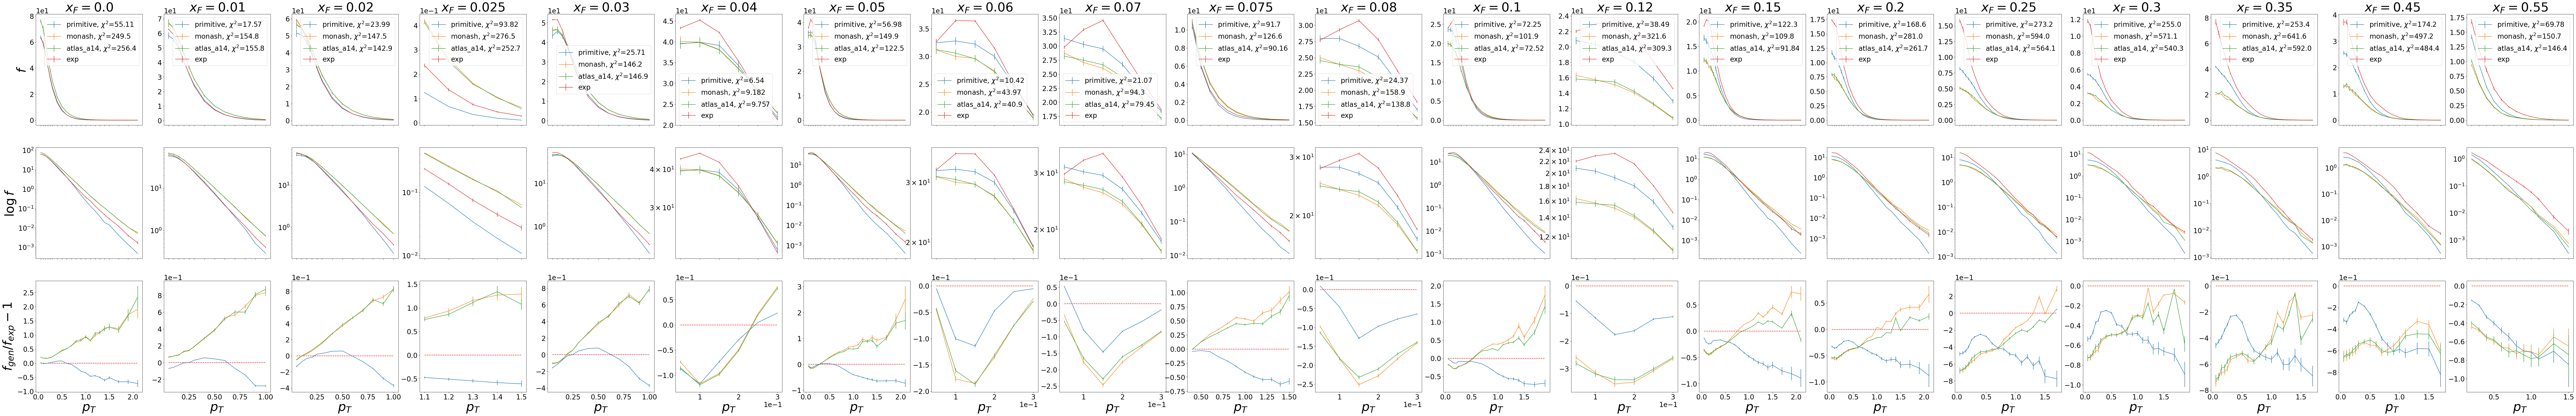

In [96]:
plot_compare(tunes.keys(), xsect, err, ref)

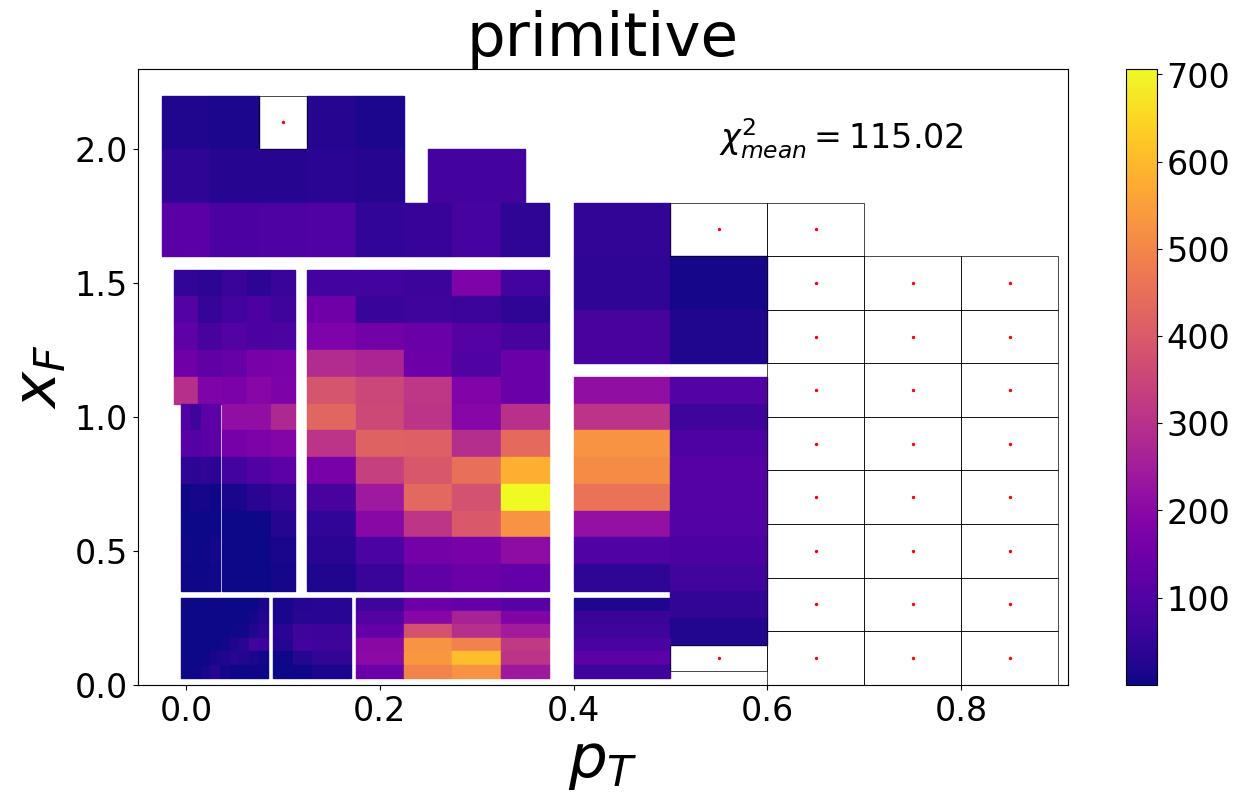

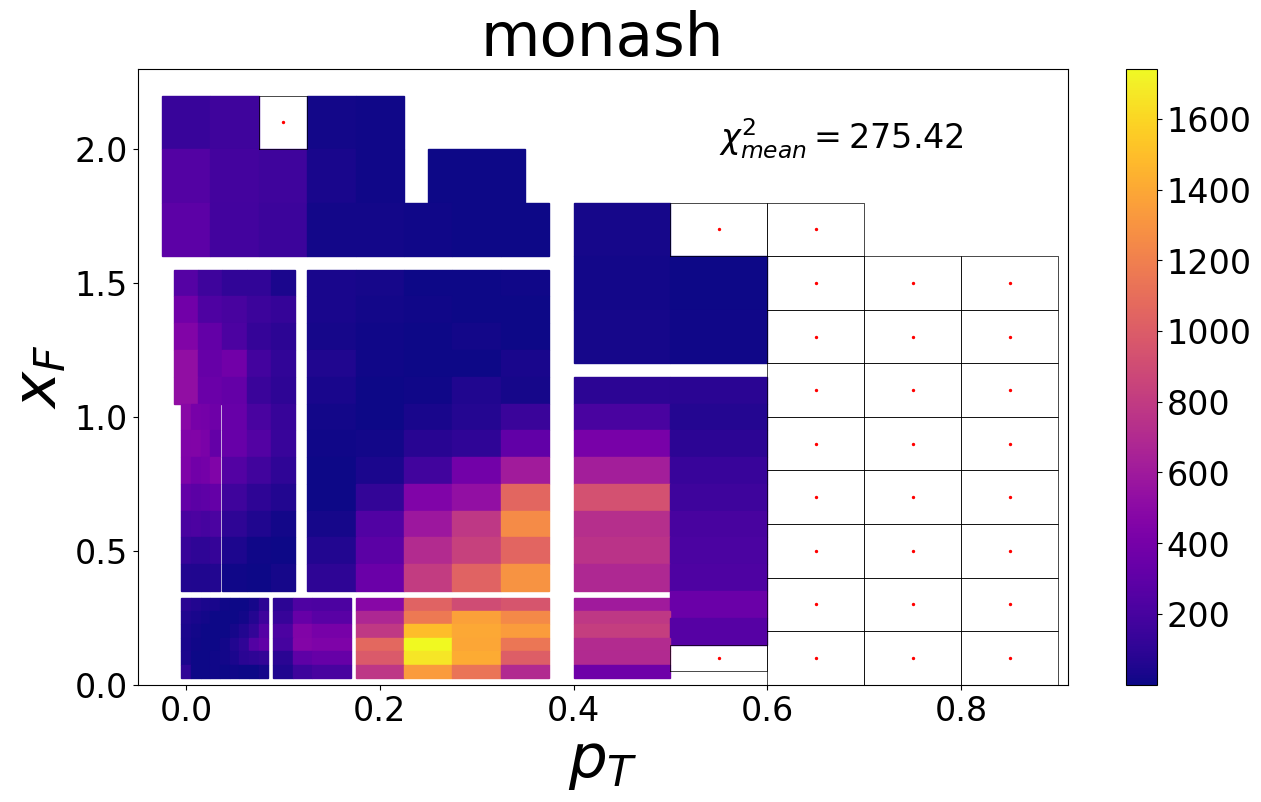

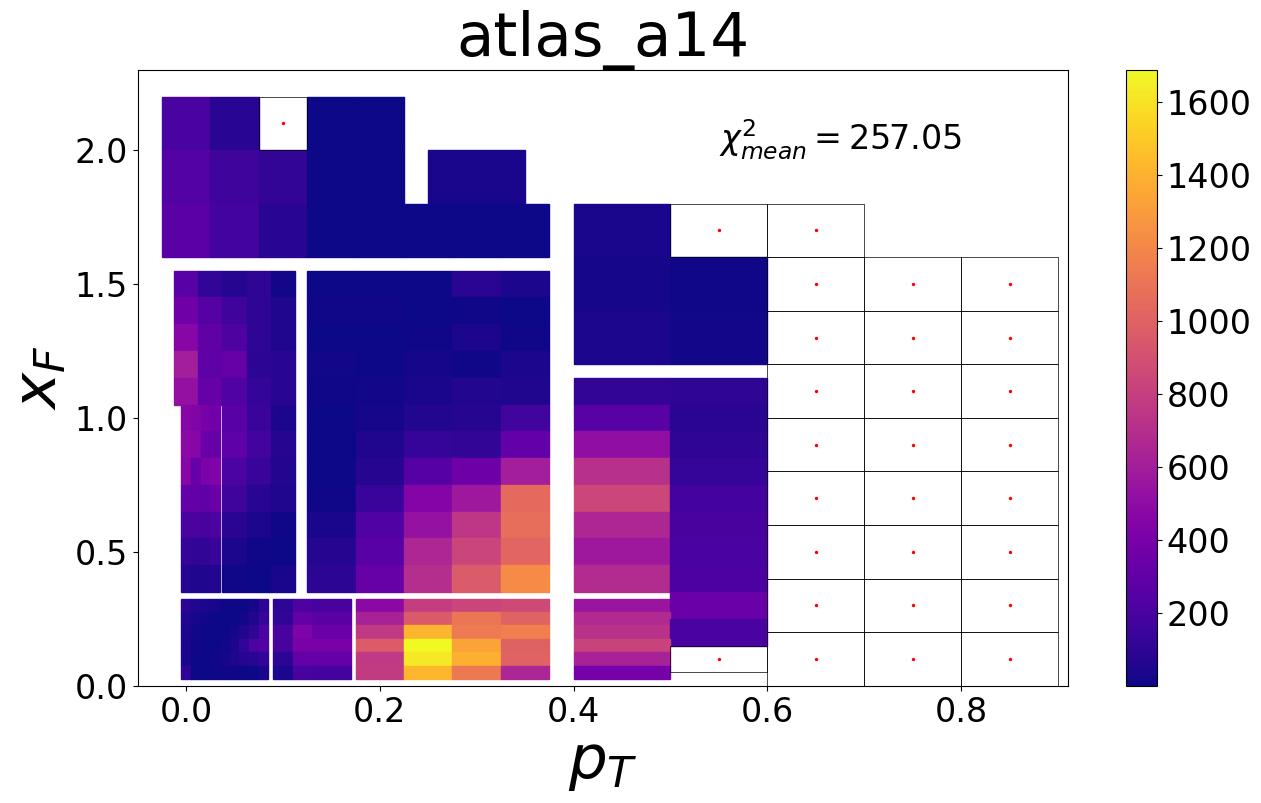

In [48]:
for tune in tunes.keys():

    plot_heat_map(xsect[tune], err[tune], ref, chi_square, title=tune)

> ## $\pi^{-}$ differential cross sectciont comparesment

In [567]:
id = -211

In [568]:
data = {}

for tune in tunes.keys():

    data[tune] = pd.read_csv(f'gen_data/{tune}/{id}.csv')

ref = pd.read_csv(f'../exp_data/na49/{id}.csv')

In [569]:
xsect = {}
err = {}

for tune in tunes.keys():

    xsect[tune], err[tune] = xsect_calc(data[tune], sig_totals[tune])

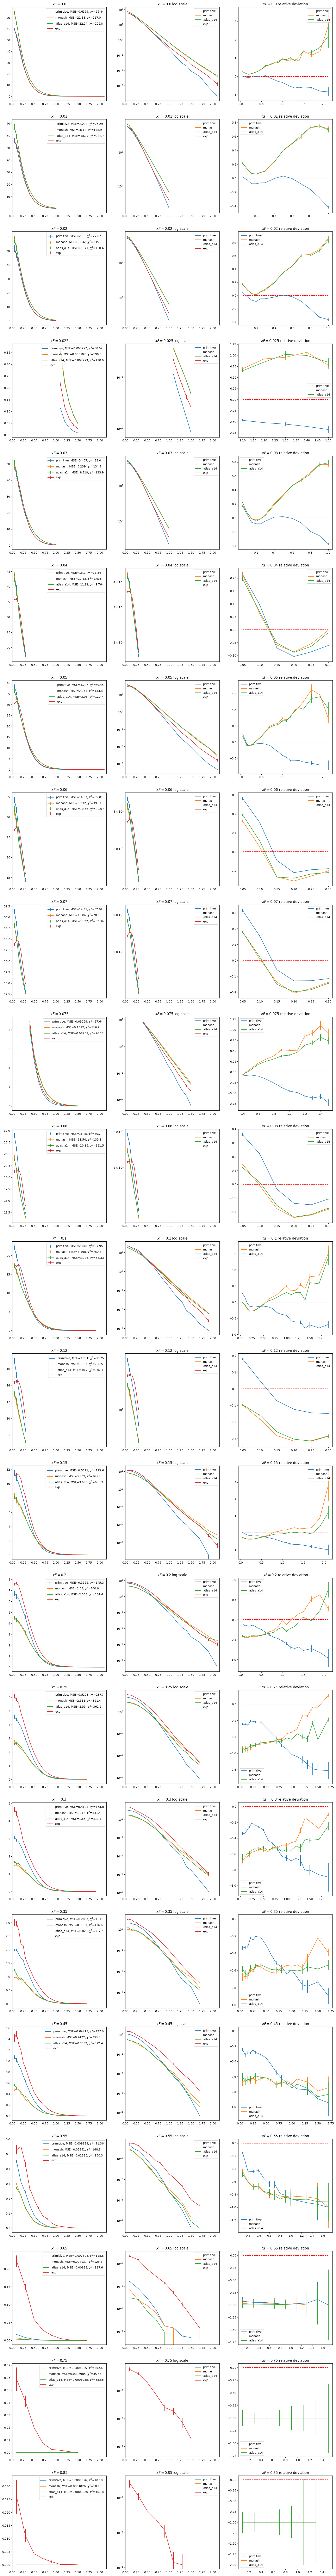

In [570]:
plot_compare(tunes.keys(), xsect, err, ref)

/var/folders/9j/cllsf0815jl9bm0yjv_8cm400000gn/T/ipykernel_93181/3748578070.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return (y_hat - y) ** 2 / (y_hat_err ** 2 + y_err ** 2)


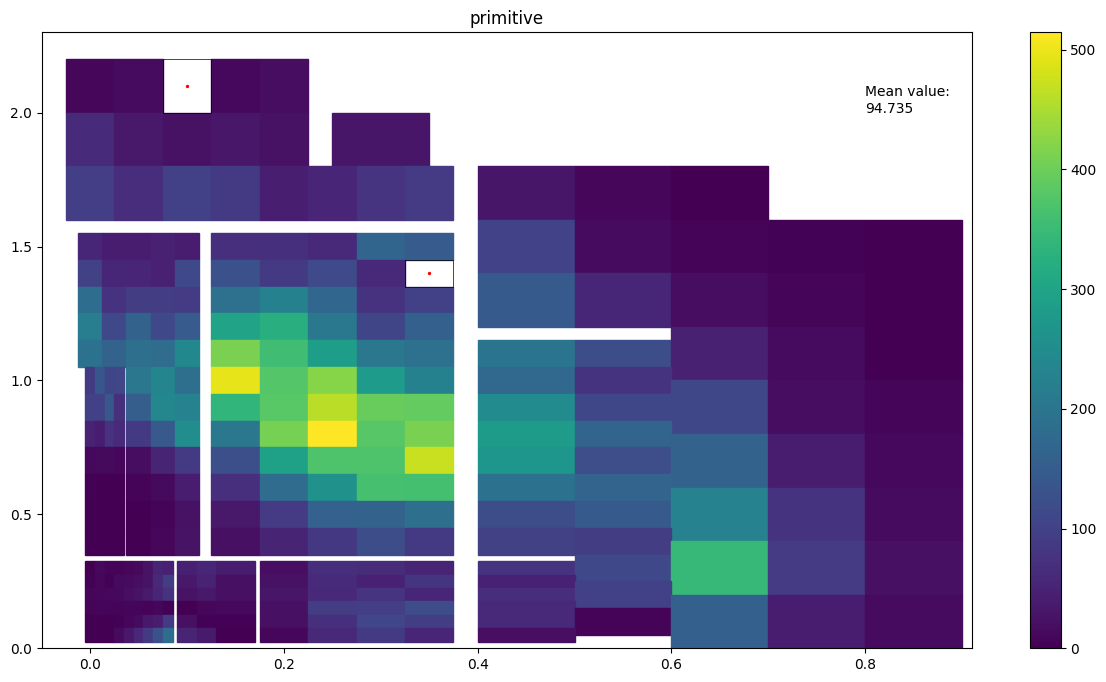

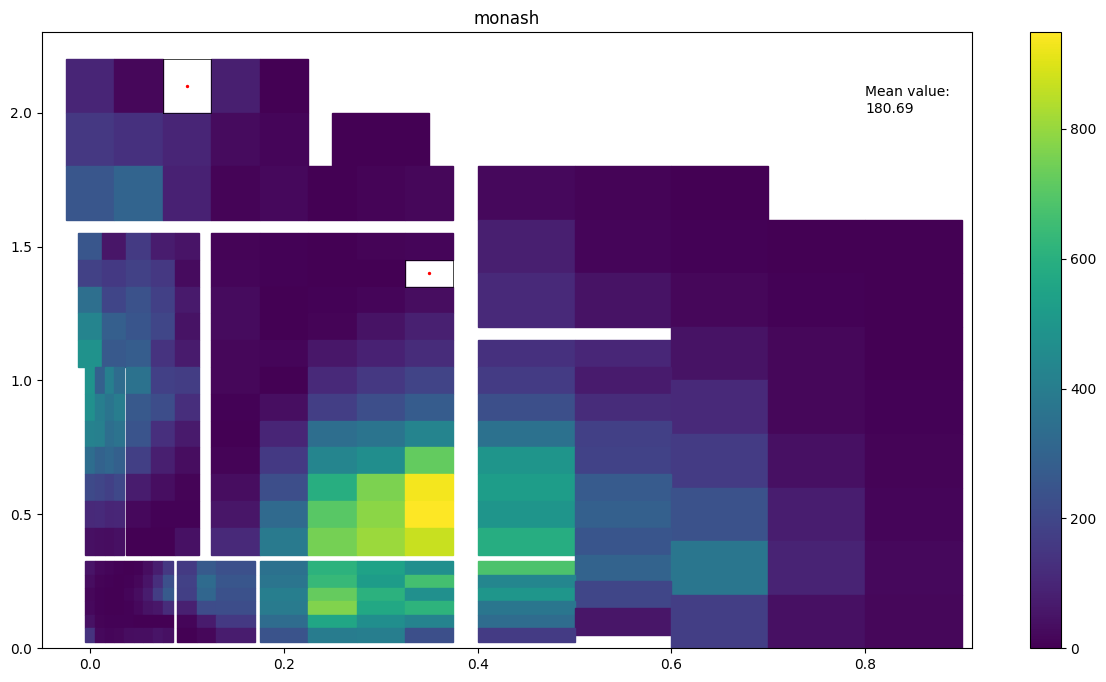

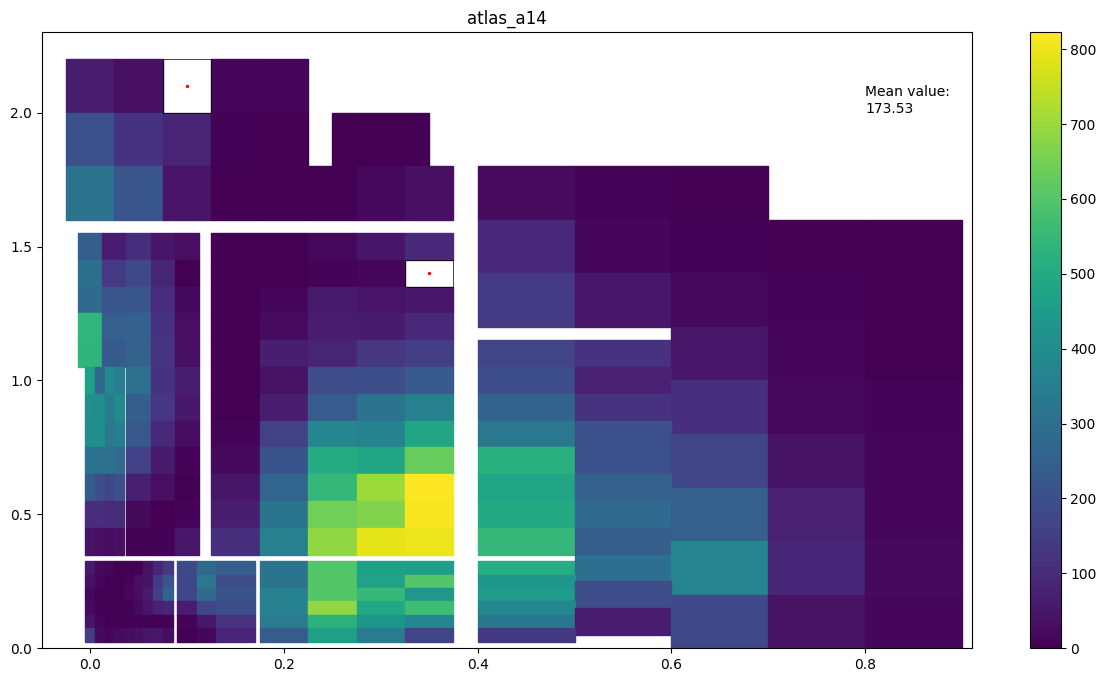

In [571]:
for tune in tunes.keys():

    plot_heat_map(xsect[tune], err[tune], ref, chi_square, title=tune)

> ## $K^{+}$ differential cross sectciont comparesment

In [572]:
id = 321

In [573]:
data = {}

for tune in tunes.keys():

    data[tune] = pd.read_csv(f'gen_data/{tune}/{id}.csv')

ref = pd.read_csv(f'../exp_data/na49/{id}.csv')

In [574]:
xsect = {}
err = {}

for tune in tunes.keys():

    xsect[tune], err[tune] = xsect_calc(data[tune], sig_totals[tune])

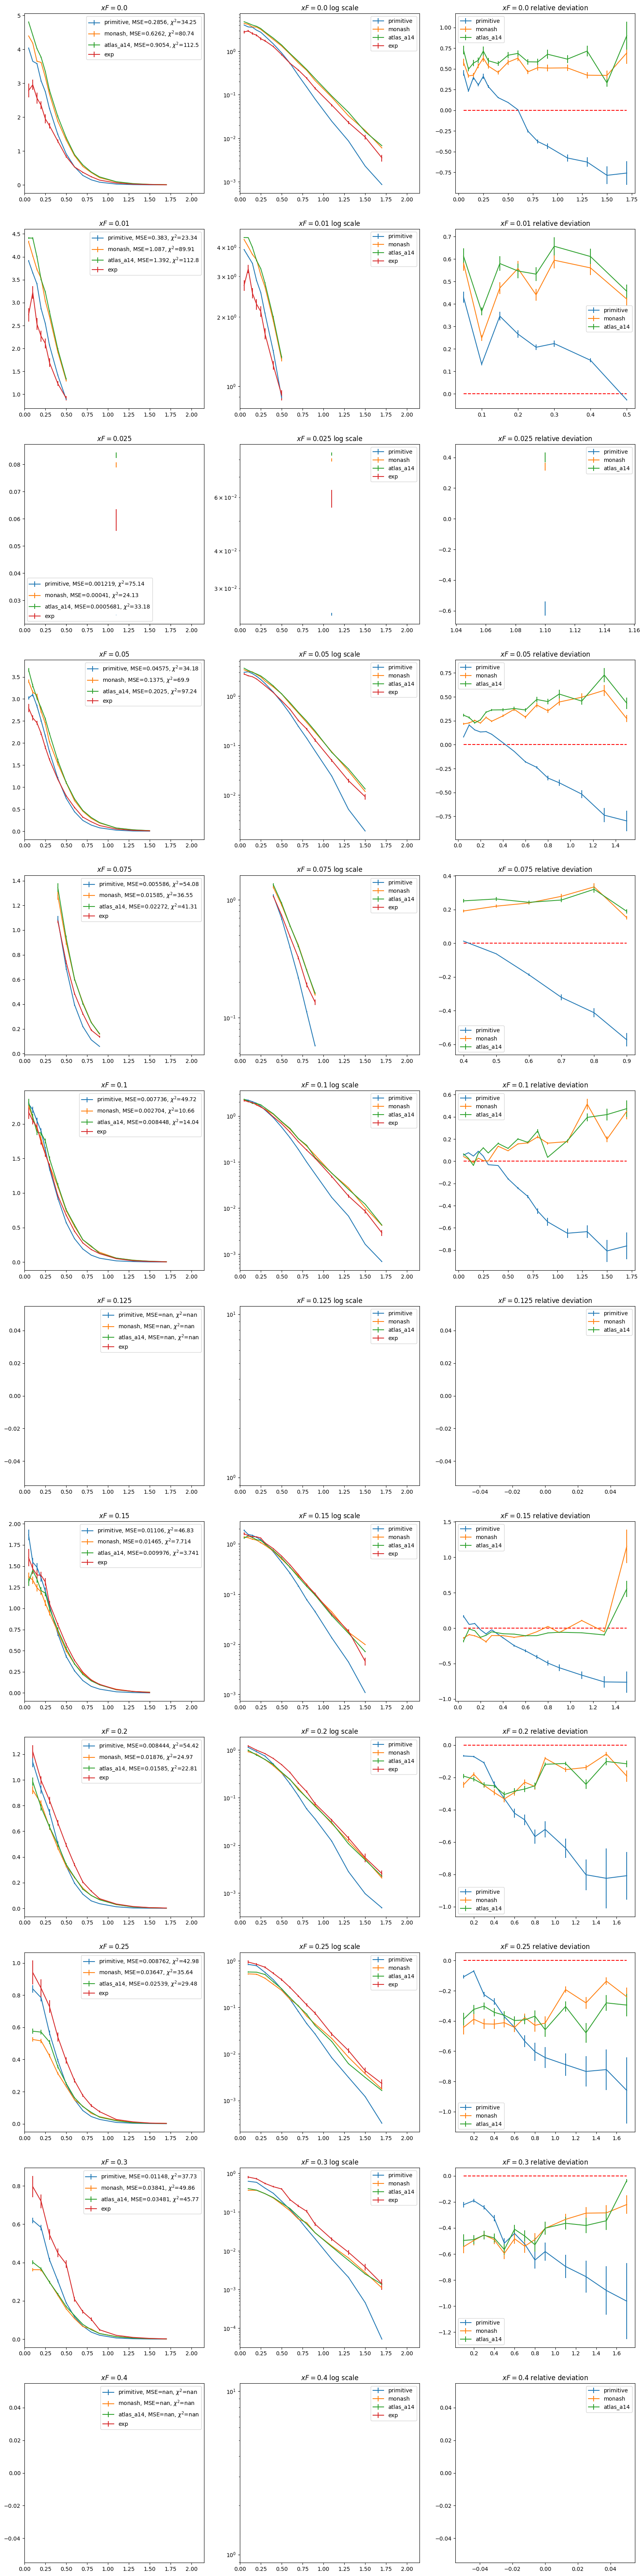

In [575]:
plot_compare(tunes.keys(), xsect, err, ref)

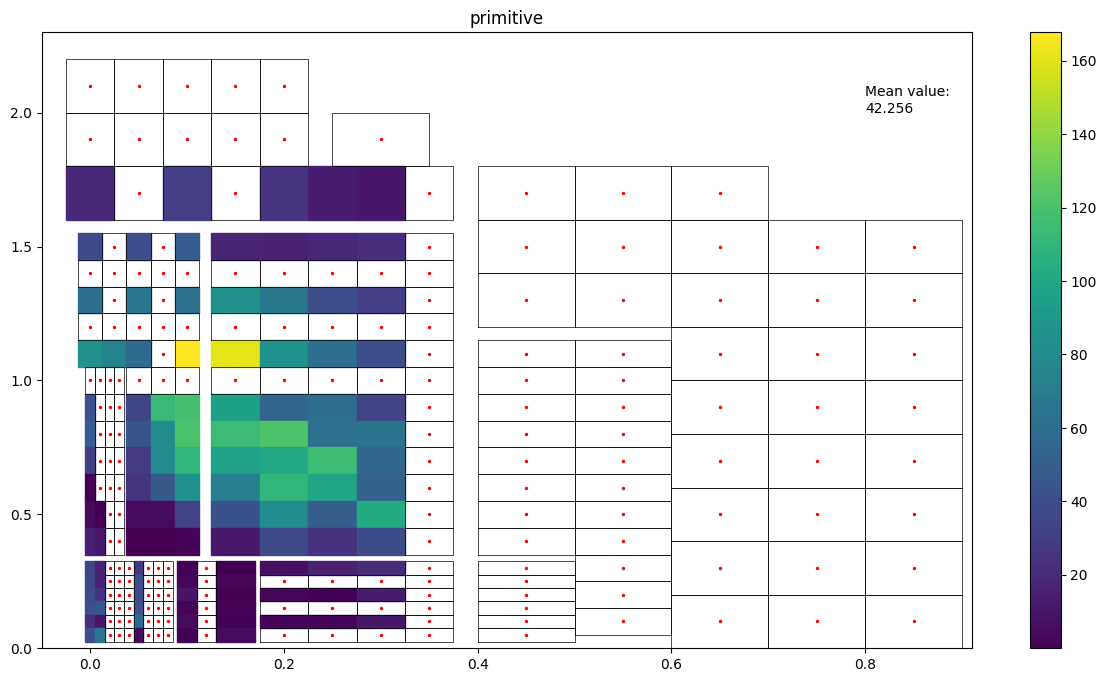

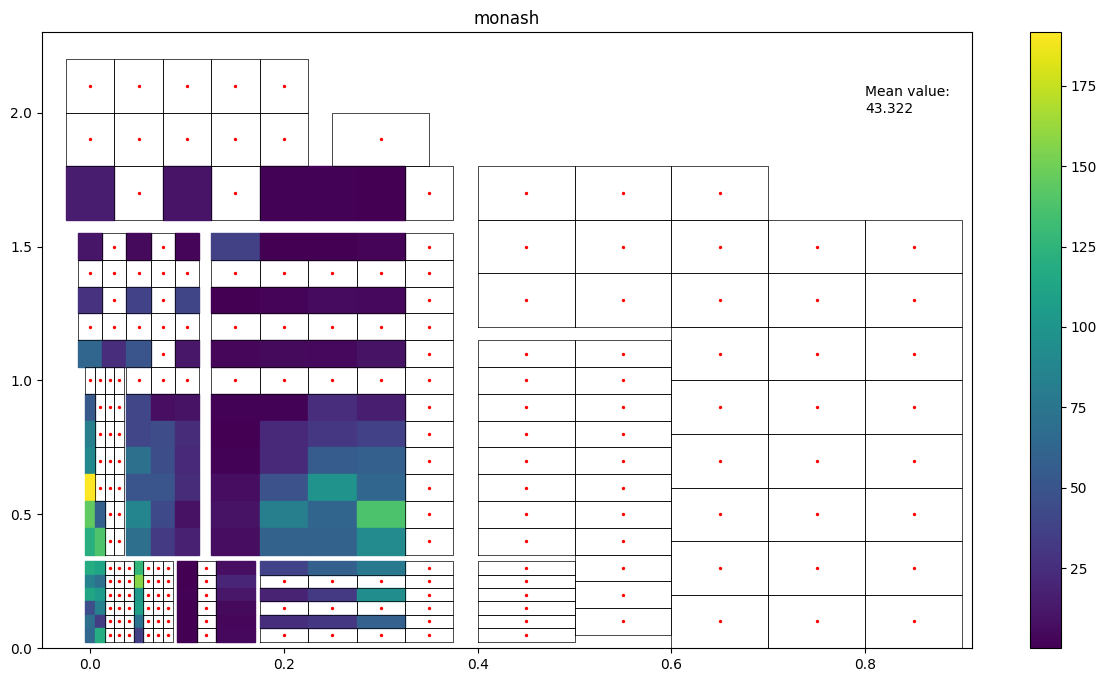

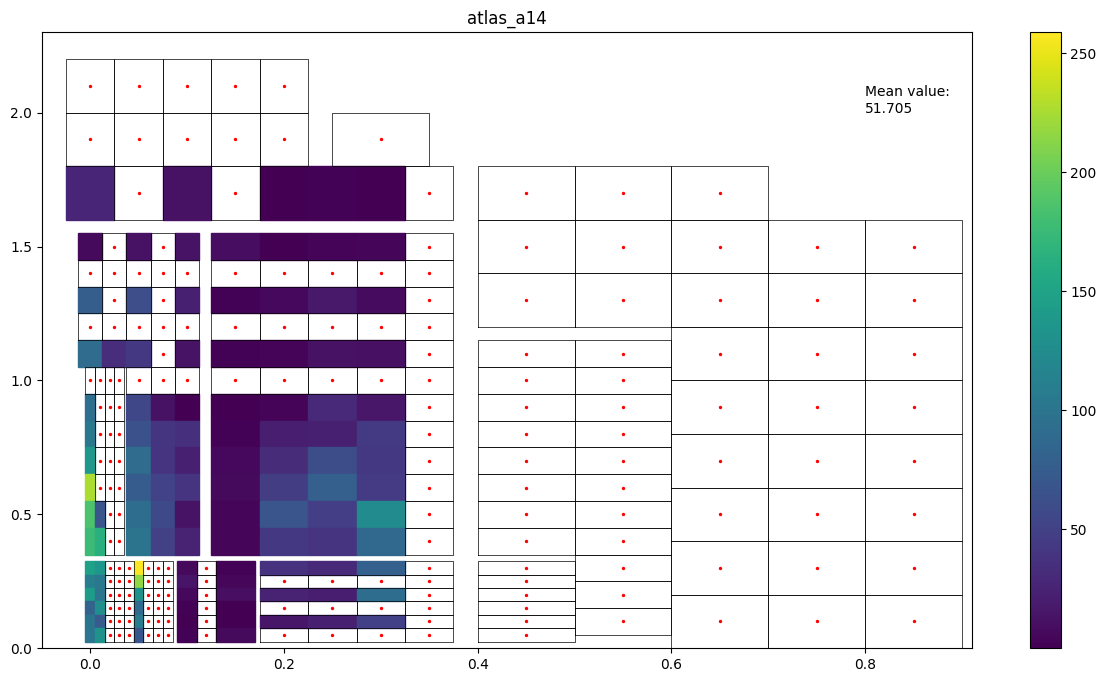

In [576]:
for tune in tunes.keys():

    plot_heat_map(xsect[tune], err[tune], ref, chi_square, title=tune)

> ## $K^{-}$ differential cross sectciont comparesment

In [577]:
id = -321

In [578]:
data = {}

for tune in tunes.keys():

    data[tune] = pd.read_csv(f'gen_data/{tune}/{id}.csv')

ref = pd.read_csv(f'../exp_data/na49/{id}.csv')

In [579]:
xsect = {}
err = {}

for tune in tunes.keys():

    xsect[tune], err[tune] = xsect_calc(data[tune], sig_totals[tune])

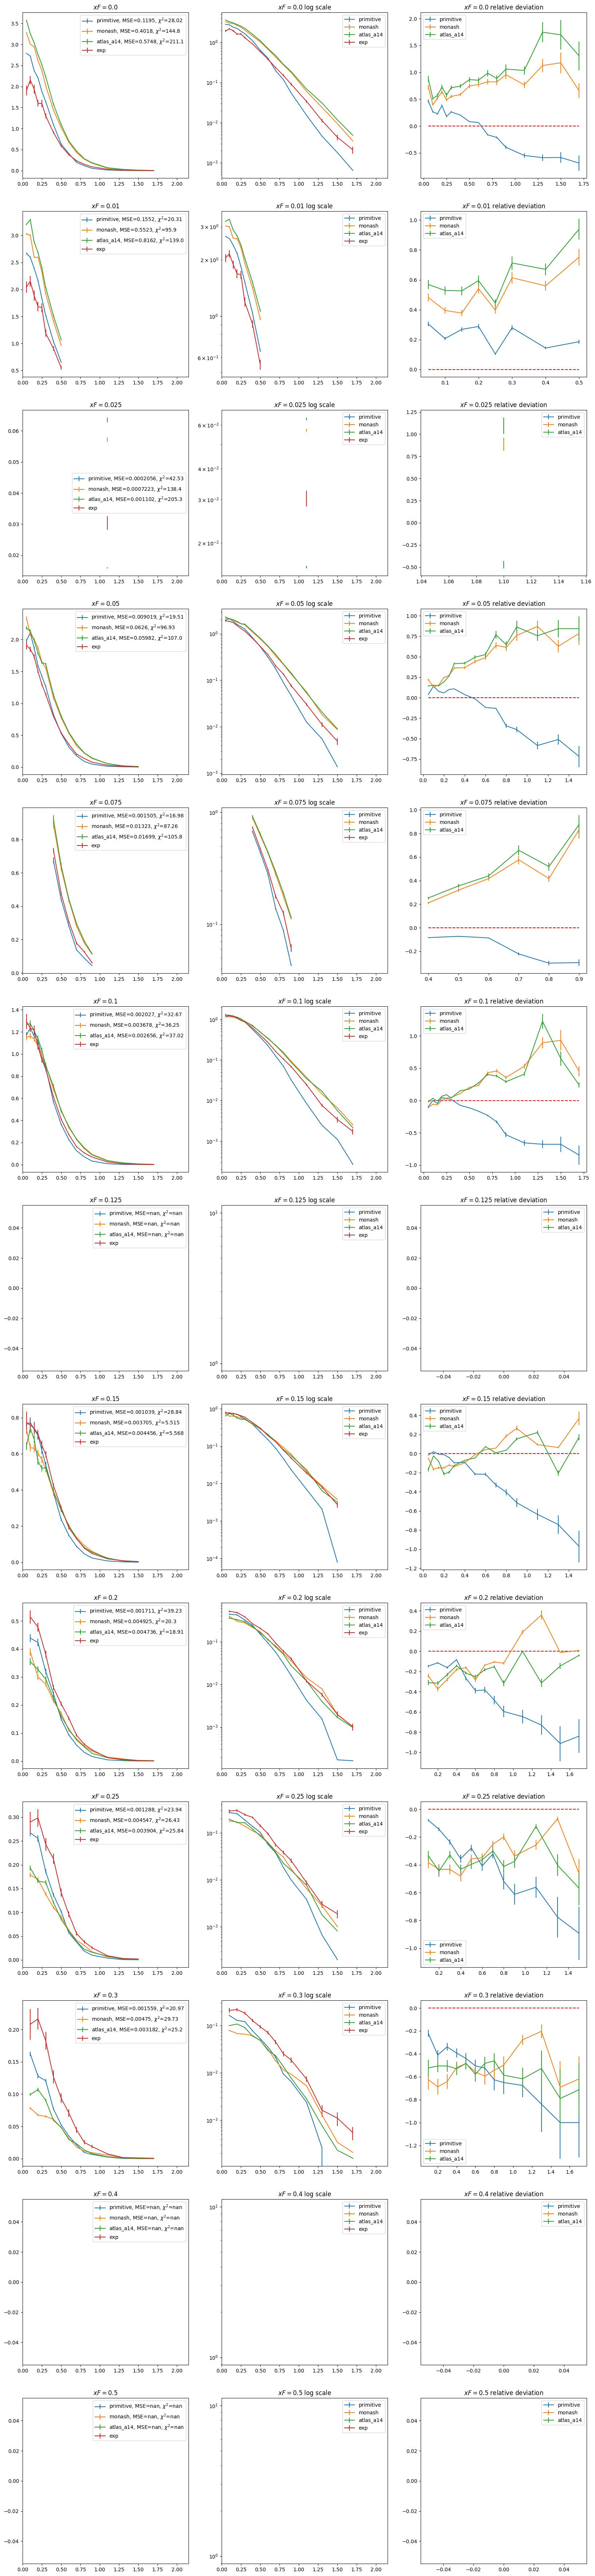

In [580]:
plot_compare(tunes.keys(), xsect, err, ref)

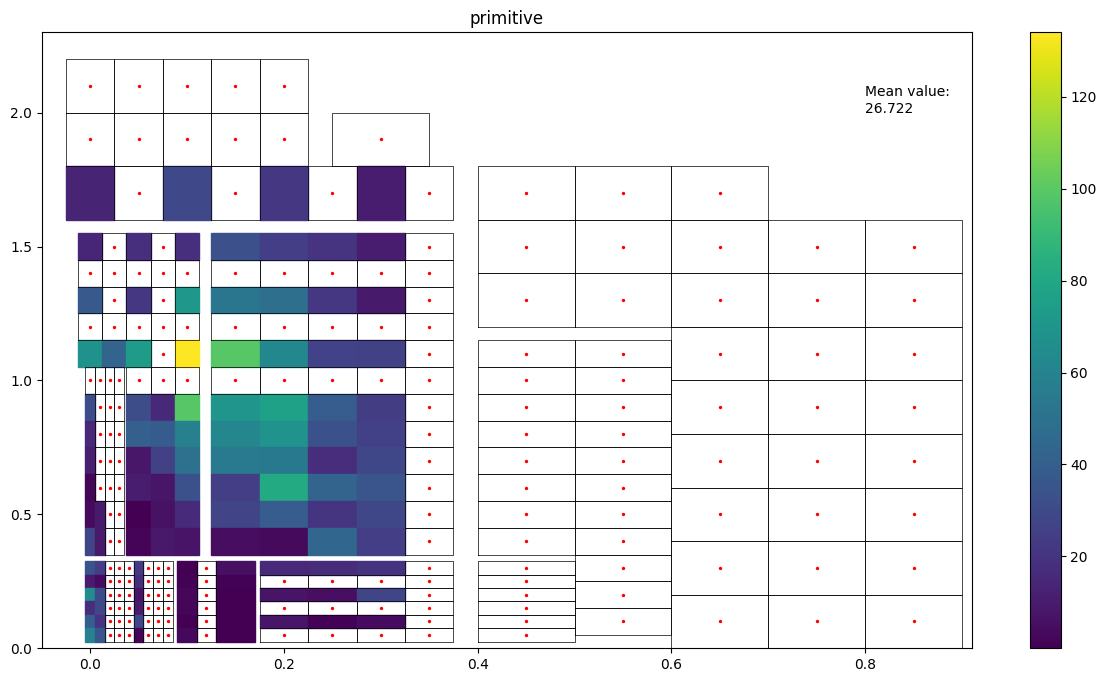

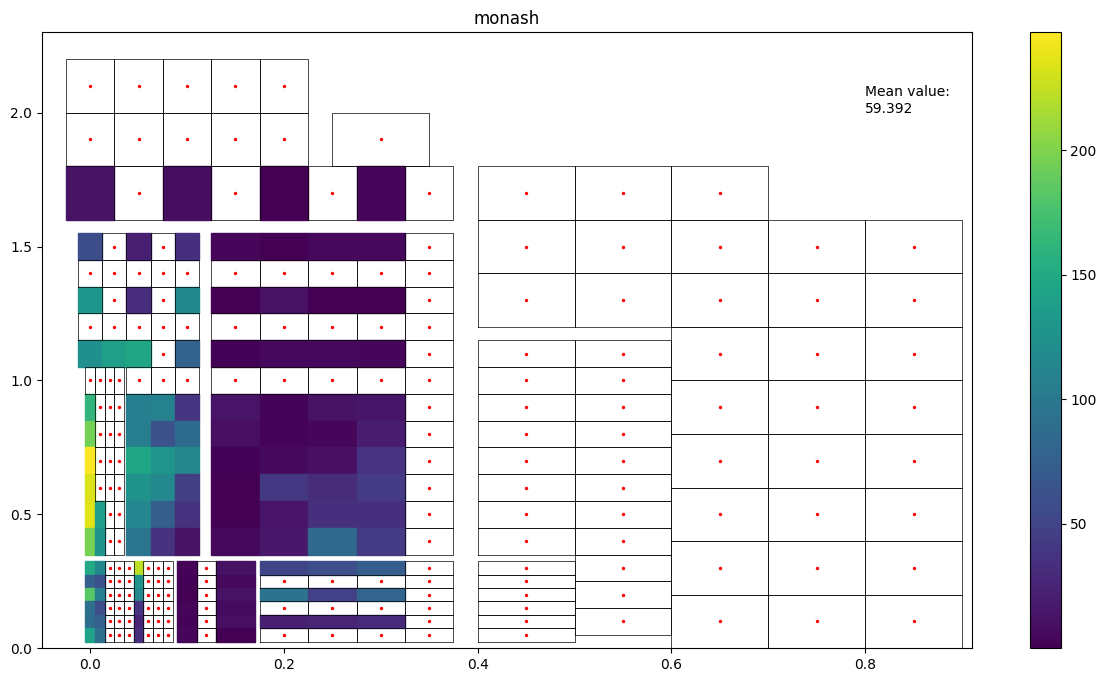

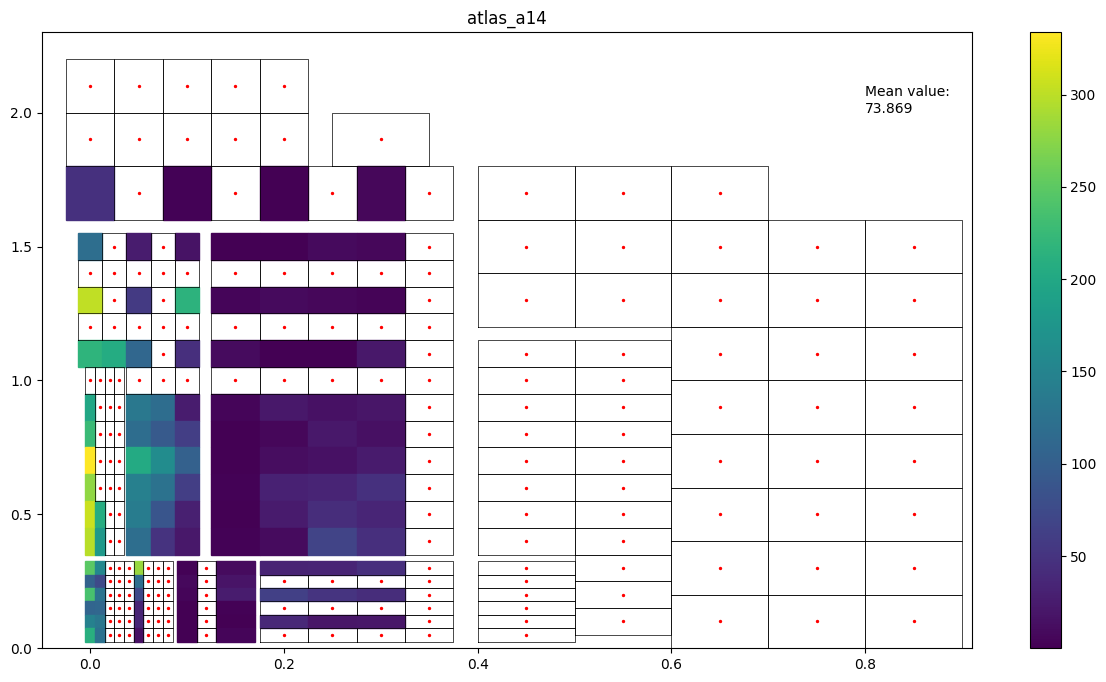

In [581]:
for tune in tunes.keys():

    plot_heat_map(xsect[tune], err[tune], ref, chi_square, title=tune)